In [41]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from shapely.ops import polygonize, cascaded_union, nearest_points
from shapely.geometry import LineString, MultiPolygon, MultiPoint, Point, shape, Polygon, LinearRing
import geopandas as gpd
import itertools
from pyhull import voronoi

### Insert here from where to read the data
base_station_location_path = '/home/lorentz/Desktop/Datasets/D4R/Base_Station_Location.txt'
district_gadm_path = '/home/lorentz/Desktop/Datasets/D4R/Census/gadm36_TUR_shp/gadm36_TUR_2.shp'
province_gadm_path = '/home/lorentz/Desktop/Datasets/D4R/Census/gadm36_TUR_shp/gadm36_TUR_1.shp'
country_gadm_path = '/home/lorentz/Desktop/Datasets/D4R/Census/gadm36_TUR_shp/gadm36_TUR_0.shp'

### Insert here where to store the data
overlap_shapefile = '/home/lorentz/Desktop/Datasets/D4R/overlap_file.shp'


# -------------------------------------------------------------------------------------------- #
### Introduce functions to evaluate the area overlap between provinces/districts and voronoi cells

def function_inters(x):
    """  Intersect polygons
    Parameters
    ----------
        x : geodataframe, contains two geometries - columns (geometry_1 and geometry_2)

    Returns
    ----------
        intersection : geoserie, intersection of geometry_1 polygons with geometry_1 polygons 
    """
    return (x['geometry_1'].intersection(x['geometry_2'])).buffer(0)


def spatial_overlays(df1, df2):
    ''' Compute overlay intersection of two GeoDataFrames df1 and df2
    Parameters
    ----------
        df1 : geodataframe, contains polygons to be intersected
        df2 : geodataframe, contains polycont to be intersected with

    Returns
    ----------
        dfinter : geodataframe, intersection of geometry_1 polygons with geometry_1 polygons 
    '''
    df1 = df1.copy()
    df2 = df2.copy()
    df1['geometry'] = df1.geometry.buffer(0)
    df2['geometry'] = df2.geometry.buffer(0)
    # Spatial Index to create intersections
    spatial_index = df2.sindex
    df1['bbox'] = df1.geometry.apply(lambda x: x.bounds)
    df1['histreg']=df1.bbox.apply(lambda x:list(spatial_index.intersection(x)))
    pairs = df1['histreg'].to_dict()
    # List the provinces/districts that intersect the bbox of the voronoi
    nei = []
    for i,j in pairs.items():
        for k in j:
            nei.append([i,k])
    
    pairs = gpd.GeoDataFrame(nei, columns=['idx1','idx2'], crs=df1.crs)
    pairs = pairs.merge(df1, left_on='idx1', right_index=True)
    pairs = pairs.merge(df2, left_on='idx2', right_index=True, suffixes=['_1','_2'])
    # Check the intersection of the voronoi with all the provinces/districts that intersected its bbox
    pairs['Intersection'] = pairs.apply(function_inters, axis=1)

    pairs = gpd.GeoDataFrame(pairs, columns=pairs.columns, crs=df1.crs)
    cols = pairs.columns.tolist()
    cols.remove('geometry_1')
    cols.remove('geometry_2')
    cols.remove('histreg')
    cols.remove('bbox')
    dfinter = pairs[cols].copy()
    dfinter.rename(columns={'Intersection':'geometry'}, inplace=True)
    dfinter = gpd.GeoDataFrame(dfinter, columns=dfinter.columns, crs=pairs.crs)
    dfinter = dfinter.loc[dfinter.geometry.is_empty==False]

    return dfinter
# -------------------------------------------------------------------------------------------- #

In [42]:
# -------------------------------------------------------------------------------------------- #
### Load GADM DATASET
polygons_gadm = gpd.read_file(province_gadm_path, encoding = 'utf-8',crs={'init' :'epsg:4326'})
turkey = gpd.read_file(country_gadm_path, encoding = 'utf-8',crs={'init' :'epsg:4326'})
turkey_shape =  turkey.geometry[0]

# -------------------------------------------------------------------------------------------- #
### Load CELLS location DATASET
cell_location = pd.read_csv(base_station_location_path, encoding = 'utf-8', error_bad_lines=False)
# Drop duplicates and compute lat lon
cell_location = cell_location.drop_duplicates(subset = ['MX_LAT1','MX_LAT2','MX_LAT3',
                                                        'MX_LONG1','MX_LONG2','MX_LONG3'])
cell_location['lat'] = cell_location.MX_LAT1+cell_location.MX_LAT2/60+cell_location.MX_LAT3/3600
cell_location['lon'] = cell_location.MX_LONG1+cell_location.MX_LONG2/60+cell_location.MX_LONG3/3600
# Remove Nans
cell_location = cell_location[['BTS_ID','lat','lon','MX_SAHAIL']].dropna().reset_index(drop=True)
points = cell_location[['lon','lat']].apply(lambda x:Point(x),axis = 1)
cell_location = gpd.GeoDataFrame(cell_location, geometry = points,crs={'init' :'epsg:4326'})
# Keep only cells that are on Turkey territory
cell_location= gpd.sjoin(cell_location,turkey, how="inner", op='within')
points = cell_location[['lon','lat']].values


In [43]:
# -------------------------------------------------------------------------------------------- #
### This is the VORONOI tessellation
vor = voronoi.VoronoiTess(points,add_bounding_box = True)
# This is to find the polygons of the Voronoi cell
edges = [[vor.vertices[i[0]],vor.vertices[i[1]]] for i in vor.ridges.values()]
aa = list(polygonize(edges))
voronoi_cells = gpd.GeoDataFrame([],geometry = aa,crs={'init' :'epsg:4326'})
# A spatial join to find the coodinate of the original cells corresponding to the VORONOI cell
merged_voronoi_cells = gpd.sjoin(cell_location[['geometry','BTS_ID']],voronoi_cells[['geometry']], how="inner", op='within')
merged_voronoi_cells['geometry_polygon'] = voronoi_cells.loc[merged_voronoi_cells.index_right]['geometry'].values
voronoi_cells = merged_voronoi_cells

In [44]:
# -------------------------------------------------------------------------------------------- #
### To restrict the VORONOI cell polygons to the region of interest (e.g. Turkey) 
# Intersection between Turkey polygon and voronoi cells
pointList = list(itertools.product(np.array(turkey_shape.bounds)[[0,2]],np.array(turkey_shape.bounds)[[1,3]]))
poly = Polygon([[p[0], p[1]] for p in np.array(pointList)[[1,0,2,3]]])

voronoi_cells['geometry_2'] = [poly]*len(voronoi_cells)
voronoi_cells['geometry_1']  = voronoi_cells['geometry_polygon']
voronoi_cells['Intersection'] = voronoi_cells.apply(function_inters, axis=1)
voronoi_cells['geometry']= voronoi_cells['Intersection']

In [45]:
# -------------------------------------------------------------------------------------------- #
### Compute the area of the cells in squared km
voronoi_cells['area']= voronoi_cells['geometry'].to_crs({'proj': 'cea'})\
               .map(lambda p: p.area / 10**6)
area_voronoi = dict(voronoi_cells[['BTS_ID','area']].values)

In [13]:
### Find the intersection between voronoi and gadm
# Takes a while to be processed
res_intersection = spatial_overlays(voronoi_cells[['geometry','BTS_ID']], polygons_gadm)

In [48]:
### Find the area of the intersection
res_intersection2 = res_intersection[['BTS_ID','NAME_1','geometry']]
crs={'init' :'epsg:4326'}
res_intersection2.crs = crs
# "area" column contains the area of the intersection between the voronoi and the province/geometry provided
res_intersection2['area'] = res_intersection2['geometry'].to_crs({'proj': 'cea'})\
                            .map(lambda p: p.area / 10**6)

### This is the fraction of the area of each GADM covered by the voronoi
# A_{c_i\cap v_j} from Deville's paper
res_intersection2['area_fraction'] = res_intersection2['area']/res_intersection2.NAME_1\
                                     .map(res_intersection2.groupby('NAME_1')['area'].sum().to_dict())
### This is the area of the voronoi 
# res_intersection2['area_voronoi'] = res_intersection2['BTS_ID'].map(area_voronoi)
res_intersection2 = res_intersection2.merge(res_intersection2.groupby('BTS_ID')\
                                            .sum()[['area']].reset_index()\
                                            .rename(columns={'area':'area_voronoi'}), on='BTS_ID')
res_intersection2 = res_intersection2.dropna()
res_intersection2.to_file(overlap_shapefile,driver = 'ESRI Shapefile', encoding = 'utf-8')

/home/lorentz/.virtualenvs/jupy_env/lib/python3.5/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lorentz/.virtualenvs/jupy_env/lib/python3.5/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


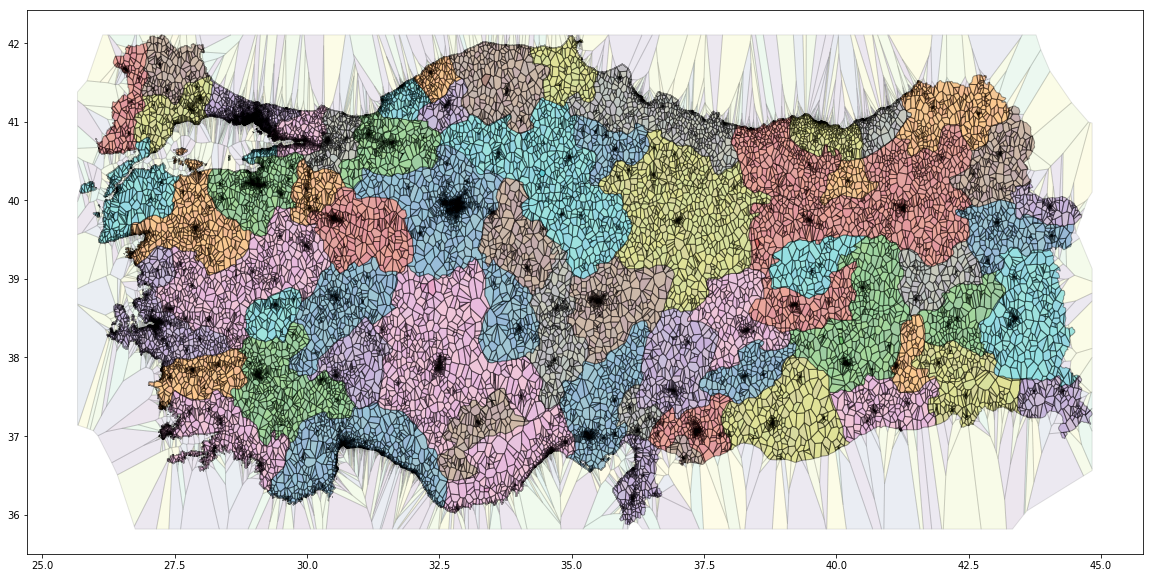

In [57]:
fig,ax = plt.subplots(figsize = (20,10))
voronoi_cells.plot(column='BTS_ID', edgecolor = 'k',alpha = 0.1,ax = ax)
res_intersection2.plot(column='NAME_1', edgecolor = 'k',alpha = 0.4,ax = ax)


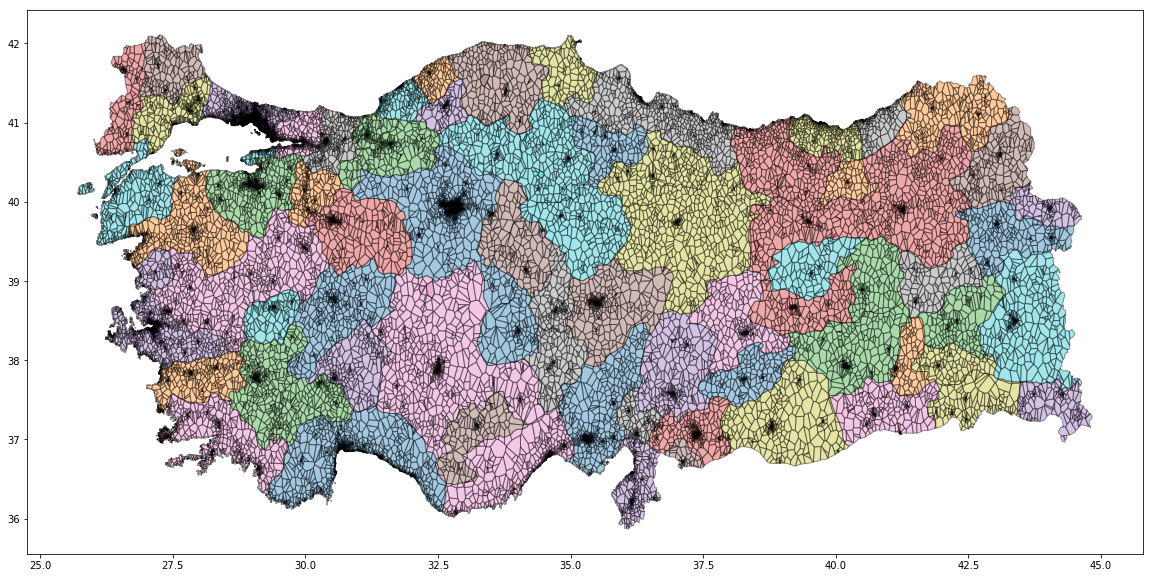

In [8]:
### Visualization of the VORONOI cells overlapped with the Turkey provinces
fig,ax = plt.subplots(figsize = (20,10))
res_intersection2.plot(column='NAME_1', edgecolor = 'k',alpha = 0.4,ax = ax)
# plt.savefig('../outputs/voronoi_cells.pdf',bbox_inches = 'tight')